In [3]:
#!/usr/bin/env python
# coding: utf-8

# Import necessary libraries
import numpy as np
import multiprocessing
from tqdm import tqdm # Progress bar
import math # For ceil function
import time # For potential debugging/timing
import os # For path joining
import traceback # For detailed error reporting

# --- LAMMPS File Parsing Functions ---

def parse_lammps_frame(frame_lines):
    """
    Parses a single frame block (list of lines) from a LAMMPS dump file.
    Handles various coordinate column names (x, xs, xu, etc.).

    Args:
        frame_lines (list): A list of strings, where each string is a line
                            belonging to a single frame in the LAMMPS file.

    Returns:
        dict or None: A dictionary containing parsed data ('timestep', 'natoms',
                      'bounds', 'atoms') or None if parsing fails or the frame
                      is incomplete. The 'atoms' entry is a list of dicts,
                      each representing an atom with 'id', 'type', 'x', 'y', 'z'.
                      'bounds' is a dict with keys 'x', 'y', 'z', each holding
                      a list [lo, hi].
    """
    data = {'timestep': None, 'natoms': None, 'bounds': {}, 'atoms': []}
    lines = iter(frame_lines) # Create an iterator for easy line processing
    atom_data_list = [] # Temporary list for atom data
    try:
        while True:
            line = next(lines).strip() # Read next line, remove whitespace

            # --- Parse different sections based on ITEM keyword ---
            if line.startswith("ITEM: TIMESTEP"):
                data['timestep'] = int(next(lines).strip())
            elif line.startswith("ITEM: NUMBER OF ATOMS"):
                data['natoms'] = int(next(lines).strip())
            elif line.startswith("ITEM: BOX BOUNDS"):
                # Assumes standard 'pp pp pp' or similar, extracts bounds
                x_bounds = list(map(float, next(lines).strip().split()))
                y_bounds = list(map(float, next(lines).strip().split()))
                z_bounds = list(map(float, next(lines).strip().split()))
                data['bounds']['x'] = x_bounds
                data['bounds']['y'] = y_bounds
                data['bounds']['z'] = z_bounds
            elif line.startswith("ITEM: ATOMS"):
                # --- Parse Atom Data ---
                columns = line.split()[2:] # Skip "ITEM:" and "ATOMS"
                try:
                    id_idx = columns.index('id')
                    type_idx = columns.index('type')
                    # Find coordinate columns (allow for variations)
                    coord_keys = {}
                    for dim in ['x', 'y', 'z']:
                        found = False
                        for suffix in ['', 's', 'u']: # Check unscaled, scaled, unwrapped
                            key = dim + suffix
                            if key in columns:
                                coord_keys[dim] = columns.index(key)
                                found = True
                                break
                        if not found:
                             raise ValueError(f"Could not find any column for dimension '{dim}' (e.g., {dim}, {dim}s, {dim}u)")

                except ValueError as e:
                    raise ValueError(f"Missing required column in ATOMS section: {e}. Found columns: {columns}")

                if data['natoms'] is None:
                    raise ValueError("ITEM: NUMBER OF ATOMS must precede ITEM: ATOMS")

                # Pre-allocate atom list if natoms is large? Not strictly necessary here.
                for i in range(data['natoms']):
                    atom_line_raw = next(lines).strip()
                    if not atom_line_raw: # Handle potential empty lines
                         # print(f"Warning: Empty line encountered in ATOMS section of frame {data.get('timestep', 'N/A')}, expected {data['natoms']} atoms, got {i}.")
                         continue # Skip this line
                    atom_line = atom_line_raw.split()
                    # Check if line has enough columns before accessing indices
                    max_idx = max(id_idx, type_idx, coord_keys['x'], coord_keys['y'], coord_keys['z'])
                    if len(atom_line) <= max_idx:
                        # print(f"Warning: Malformed atom line in frame {data.get('timestep', 'N/A')}: '{atom_line_raw}'. Skipping.")
                        continue # Skip malformed line

                    atom_data = {
                        'id': int(atom_line[id_idx]),
                        'type': int(atom_line[type_idx]),
                        'x': float(atom_line[coord_keys['x']]),
                        'y': float(atom_line[coord_keys['y']]),
                        'z': float(atom_line[coord_keys['z']]),
                    }
                    atom_data_list.append(atom_data)

                data['atoms'] = atom_data_list
                break # Exit the while loop after processing the ATOMS section

    except StopIteration:
        pass # Expected at end of frame lines
    except ValueError as e:
         # print(f"Warning: Error parsing frame data: {e}") # Optional debug
         return None # Indicate parsing failure
    except IndexError as e:
         # print(f"Warning: Error parsing atom line (IndexError): {e}. Line: '{atom_line_raw if 'atom_line_raw' in locals() else 'N/A'}'") # Optional debug
         return None

    # --- Basic Validation ---
    if data['timestep'] is None or data['natoms'] is None or not data['bounds']:
       return None # Indicate incomplete frame header info
    # Check if number of parsed atoms matches expected number (optional, can be slow)
    # if len(data.get('atoms', [])) != data.get('natoms'):
        # print(f"Warning: Frame {data.get('timestep', 'N/A')} - Expected {data['natoms']} atoms, but parsed {len(data.get('atoms', []))}.")
        # return None # Decide if this is critical

    return data


def read_lammps_frames(filename):
    """
    Generator function to read a LAMMPS dump file and yield frames one by one.
    Each frame is yielded as a list of its constituent lines.

    Args:
        filename (str): Path to the LAMMPS dump file.

    Yields:
        list: A list of strings representing the lines of a single frame.
    """
    current_frame_lines = []
    try:
        with open(filename, 'r') as f:
            for line in f:
                # Start of a new frame (and not the very first line)
                if line.startswith("ITEM: TIMESTEP") and current_frame_lines:
                    yield current_frame_lines # Yield the completed previous frame
                    current_frame_lines = [line] # Start the new frame
                else:
                    current_frame_lines.append(line) # Add line to the current frame

            # Yield the very last frame in the file after the loop finishes
            if current_frame_lines:
                yield current_frame_lines
    except FileNotFoundError:
        print(f"Error: Input trajectory file not found at '{filename}'")
        raise # Re-raise the exception to stop execution
    except Exception as e:
        print(f"Error reading file '{filename}': {e}")
        raise # Re-raise other potential file reading errors


# --- Parallel Processing Functions ---

def find_min_max_z_in_frame(args):
    """
    Worker function for Pass 1: Finds min/max Z for a specific atom type in one frame.

    Args:
        args (tuple): A tuple containing:
            - frame_lines (list): Lines of text for one frame.
            - atom_type (int): The atom type to filter by.

    Returns:
        tuple: (min_z, max_z) found in this frame for the atom type.
               Returns (np.inf, -np.inf) if no atoms of the type are found or on error.
    """
    frame_lines, atom_type = args
    min_z, max_z = np.inf, -np.inf

    parsed_data = parse_lammps_frame(frame_lines)
    if parsed_data is None or not parsed_data.get('atoms'):
        return min_z, max_z # Return defaults if frame invalid or no atoms

    # --- Filter atoms and find min/max Z ---
    # Using list comprehension and min/max for potential minor speedup
    z_values = [atom['z'] for atom in parsed_data['atoms'] if atom['type'] == atom_type]
    if z_values: # Check if list is not empty
        min_z = min(z_values)
        max_z = max(z_values)

    return min_z, max_z


def process_frame_for_hist(args):
    """
    Worker function for Pass 2: Calculates Z-histogram and Lx*Ly for one frame using predefined bins.

    Args:
        args (tuple): A tuple containing:
            - frame_lines (list): Lines of text for one frame.
            - atom_type (int): The atom type to filter by.
            - bin_edges (np.ndarray): The predefined edges for the Z histogram bins.

    Returns:
        tuple: A tuple containing:
            - counts (np.ndarray or None): Histogram counts for the frame, or None on error.
            - LxLy (float): The product of box dimensions Lx * Ly for the frame.
    """
    frame_lines, atom_type, bin_edges = args # Unpack arguments

    parsed_data = parse_lammps_frame(frame_lines)
    if parsed_data is None:
        return None, 0.0 # Indicate failure or incomplete frame

    # --- Filter atoms and extract Z coordinates ---
    z_coords = [atom['z'] for atom in parsed_data['atoms'] if atom['type'] == atom_type]

    if not z_coords:
        num_bins = len(bin_edges) - 1
        return np.zeros(num_bins, dtype=int), 0.0 # Return zero counts and zero area

    z_coords = np.array(z_coords)

    # --- Calculate Lx and Ly for this frame ---
    try:
        xlo, xhi = parsed_data['bounds']['x']
        ylo, yhi = parsed_data['bounds']['y']
        Lx = xhi - xlo
        Ly = yhi - ylo
        LxLy = Lx * Ly
        if Lx <= 0 or Ly <= 0:
             LxLy = 0.0 # Discard contribution if box is invalid
    except KeyError:
        return None, 0.0 # Cannot calculate density without box size

    # --- Calculate histogram counts for Z coordinates ---
    try:
        # Note: np.histogram automatically ignores values outside the bin_edges range
        counts, _ = np.histogram(z_coords, bins=bin_edges)
    except Exception as e:
        # print(f"Warning: Error calculating histogram for frame {parsed_data.get('timestep', 'N/A')}: {e}") # Optional debug
        return None, 0.0

    return counts, LxLy


# --- Main Computation Function ---

def compute_density_profile_manual(traj_file, output_file, atom_type=1, delta=0.1, ncore=10, filter_range=5.0, extend_range=5.0):
    """
    Computes the Z-axis density profile.
    Pass 1: Finds the actual min/max Z range of the specified atom type.
    Pass 2: Calculates density over an extended range [minZ - extend_range, maxZ + extend_range].
    Includes centering, optional filtering, and re-centering based on filter_range.

    Args:
        traj_file (str): Path to the input LAMMPS trajectory file.
        output_file (str): Path to the output file for the density profile.
        atom_type (int, optional): The type ID of the atoms to analyze. Defaults to 1.
        delta (float, optional): The desired width (resolution) of the bins
                                 along the Z-axis. Defaults to 0.1.
        ncore (int, optional): The number of CPU cores to use for parallel
                               processing. Defaults to 10.
        filter_range (float or None, optional): The range (+/-) around Z=0 to keep
                                        after initial centering. If None, no
                                        filtering/re-centering is performed. Defaults to 5.0.
        extend_range (float, optional): Value to extend the detected min/max Z range
                                       for binning. Defaults to 5.0.
    """
    print("-" * 60)
    print(f"Starting density profile calculation (Extended Data-Range Bins):")
    print(f"  Input Trajectory: '{traj_file}'")
    print(f"  Output Profile:   '{output_file}'")
    print(f"  Atom Type:        {atom_type}")
    print(f"  Bin Width (Δz):   {delta}")
    print(f"  CPU Cores:        {ncore}")
    print(f"  Bin Range Ext:    +/- {extend_range:.2f} beyond data min/max")
    if filter_range is not None:
        print(f"  Filter Range:     +/- {filter_range:.2f} around Z=0 (applied after calc)")
    else:
        print("  Filter Range:     None (full extended profile will be saved)")
    print("-" * 60)

    if delta <= 0:
        print(f"Error: Bin width 'delta' must be positive (got {delta}).")
        return None, None
    if extend_range < 0:
        print(f"Warning: extend_range is negative ({extend_range}). Using 0.0 instead.")
        extend_range = 0.0

    # --- Pass 1: Find Global Min/Max Z for the specified atom type ---
    print(f"--- Pass 1: Finding Z range for atom type {atom_type} ---")
    global_z_min, global_z_max = np.inf, -np.inf
    pass1_frame_count = 0

    # Estimate total frames for progress bar (can be reused for Pass 2)
    total_frames_estimate = 0
    try:
        print("Estimating total frames...")
        frame_gen_count = read_lammps_frames(traj_file)
        total_frames_estimate = sum(1 for _ in frame_gen_count)
        del frame_gen_count
        if total_frames_estimate == 0:
            print("Error: Trajectory file appears empty.")
            return None, None
        print(f"  Estimated {total_frames_estimate} frames.")
    except FileNotFoundError:
        # Error already printed by read_lammps_frames
        return None, None
    except Exception as e:
        print(f"  Warning: Could not estimate total frames ({e}). Progress bar may be inaccurate.")
        total_frames_estimate = None

    # Prepare arguments for Pass 1 workers
    try:
        pass1_frame_generator = read_lammps_frames(traj_file)
    except FileNotFoundError:
         return None, None # Exit if file not found here too
    pass1_map_args = ((frame_lines, atom_type) for frame_lines in pass1_frame_generator)

    try:
        with multiprocessing.Pool(processes=ncore) as pool:
            chunk_size = max(1, total_frames_estimate // (ncore * 4)) if total_frames_estimate else 100
            results_iterator = pool.imap_unordered(
                find_min_max_z_in_frame,
                pass1_map_args,
                chunksize=chunk_size
            )

            for min_z, max_z in tqdm(results_iterator, total=total_frames_estimate, desc="Pass 1: Scanning Z", unit="frame"):
                if min_z < global_z_min: global_z_min = min_z
                if max_z > global_z_max: global_z_max = max_z
                pass1_frame_count += 1 # Count frames processed in pass 1

    except KeyboardInterrupt:
         print("\nCalculation interrupted by user during Pass 1.")
         return None, None
    except Exception as e:
        print(f"\nAn error occurred during Pass 1 parallel processing: {e}")
        traceback.print_exc()
        return None, None

    print(f"Pass 1 complete. Processed ~{pass1_frame_count} frames.")

    # --- Validate Z range found ---
    if not np.isfinite(global_z_min) or not np.isfinite(global_z_max):
        print(f"Error: No atoms of type {atom_type} found in the trajectory.")
        return None, None

    print(f"  Detected Z Range for Atom Type {atom_type}: [{global_z_min:.4f}, {global_z_max:.4f}]")

    # --- Define Bins based on the EXTENDED Z range ---
    bin_z_min = global_z_min - extend_range
    bin_z_max = global_z_max + extend_range
    print(f"  Extended Z Range for Binning:      [{bin_z_min:.4f}, {bin_z_max:.4f}]")

    Lz_binned = bin_z_max - bin_z_min
    if Lz_binned <= 0:
        print(f"Error: Extended Z range for binning is zero or negative ({Lz_binned:.4e}).")
        print(f"       Check min/max Z values and extend_range.")
        # Fallback: use original range if extension caused issues? Or just error out.
        return None, None

    num_bins = math.ceil(Lz_binned / delta)
    if num_bins <= 0:
        print(f"Error: Calculated number of bins is zero or negative ({num_bins}). Check delta and extended Z range.")
        return None, None

    # Define bin edges using the extended data range
    # Add a tiny epsilon to the end to ensure the max value falls into the last bin
    bin_edges = np.linspace(bin_z_min, bin_z_max + 1e-9, num_bins + 1)

    print(f"  Number of bins:   {num_bins}")
    print(f"  Final bin edges:  [{bin_edges[0]:.4f}, {bin_edges[-1]:.4f}]")

    # --- Pass 2: Calculate Histogram using the defined bins ---
    print("\n--- Pass 2: Calculating density profile within extended Z range ---")
    total_counts = np.zeros(num_bins, dtype=np.int64)
    total_LxLy = 0.0
    pass2_frame_count = 0 # Count successfully processed frames in pass 2

    # Create a fresh generator for Pass 2
    try:
        pass2_frame_generator = read_lammps_frames(traj_file)
    except FileNotFoundError:
         # Should have been caught earlier, but check again
         return None, None
    pass2_map_args = ((frame_lines, atom_type, bin_edges) for frame_lines in pass2_frame_generator)

    try:
        with multiprocessing.Pool(processes=ncore) as pool:
            chunk_size = max(1, total_frames_estimate // (ncore * 4)) if total_frames_estimate else 100
            results_iterator = pool.imap_unordered(
                process_frame_for_hist,
                pass2_map_args,
                chunksize=chunk_size
            )

            for counts, LxLy in tqdm(results_iterator, total=total_frames_estimate, desc="Pass 2: Histogram", unit="frame"):
                if counts is not None: # Check if frame processed successfully
                    total_counts += counts
                    total_LxLy += LxLy
                    pass2_frame_count += 1

    except KeyboardInterrupt:
         print("\nCalculation interrupted by user during Pass 2.")
         return None, None
    except Exception as e:
        print(f"\nAn error occurred during Pass 2 parallel processing: {e}")
        traceback.print_exc()
        return None, None

    print(f"Pass 2 complete.")

    # --- Validation after Pass 2 ---
    if pass2_frame_count == 0:
        print("\nError: No frames were successfully processed in Pass 2.")
        return None, None
    if total_LxLy <= 0:
         print(f"\nError: Sum of Lx*Ly across frames is zero or negative ({total_LxLy:.4e}) after Pass 2.")
         return None, None

    print(f"  Successfully processed {pass2_frame_count} frames for histogram.")

    # --- Calculate Density ---
    print("Calculating final density...")
    average_LxLy = total_LxLy / pass2_frame_count
    bin_volume = average_LxLy * delta # Volume of one slice

    if bin_volume <= 0:
         print(f"Error: Calculated average bin volume is zero or negative ({bin_volume:.4e}).")
         return None, None

    average_counts_per_frame = total_counts / pass2_frame_count
    density = average_counts_per_frame / bin_volume

    # --- Center Z coordinates (Initial Centering) ---
    z_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    # Center based on the mean of the bin centers used for calculation
    midpoint = np.mean(z_centers)
    z_centers_shifted = z_centers - midpoint
    print(f"  Calculated initial Z midpoint for centering (based on extended bins): {midpoint:.4f}")

    # --- Optional Filtering and Re-centering ---
    if filter_range is not None:
        print(f"Filtering data to keep initially centered Z within [{-filter_range:.2f}, {filter_range:.2f}]...")
        filter_mask = (z_centers_shifted >= -filter_range) & (z_centers_shifted <= filter_range)

        z_filtered = z_centers_shifted[filter_mask]
        density_filtered = density[filter_mask]

        if z_filtered.size == 0:
            print("Warning: No data points remain after filtering.")
            z_final = np.array([])
            density_final = np.array([])
            print(f"Saving empty profile to '{output_file}'...")
        else:
            print(f"  {z_filtered.size} data points remain after filtering.")
            # Re-center Filtered Data
            filtered_midpoint = np.mean(z_filtered)
            z_final = z_filtered - filtered_midpoint
            density_final = density_filtered
            print(f"  Re-centered filtered data around Z = {filtered_midpoint:.4f} -> 0")
            output_header = '# Filtered_ReCentered_Z_Coordinate Number_Density'
    else:
        # No filtering, use the initially centered data from the extended range calculation
        print("Skipping filtering step as filter_range is None.")
        z_final = z_centers_shifted
        density_final = density
        output_header = '# Centered_Z_Coordinate Number_Density'


    # --- Save Output ---
    print(f"Saving final density profile to '{output_file}'...")
    data_to_save = np.vstack((z_final, density_final)).T

    try:
        np.savetxt(output_file, data_to_save,
                   header=output_header,
                   fmt='%.6e', delimiter=' ')
        print("Done!")
        print("-" * 60)
    except Exception as e:
        print(f"Error saving output file '{output_file}': {e}")
        traceback.print_exc()
        print("-" * 60)

    # Return the final data
    return z_final, density_final


# --- Main Execution Block ---

if __name__ == '__main__':
    # This check is crucial for multiprocessing to work correctly.

    # --- Set Parameters ---
    # !!! Replace with the actual path to your LAMMPS trajectory file !!!
    trajectory_file_path = "/expanse/lustre/scratch/dham/temp_project/slab_na/test/na_cation/NaFSI_Me2O_DFM/analysis_nvt.lammpstrj" # Example path

    # Define output file path
    output_profile_path = os.path.join(".", 'density_profile.txt') # New output name

        # Store files 
    species = [
        (4, "FSI- (NBT)"),
        (2, "Na+"),
        (16, "DFM"),
        (7, "MEO")
    ]

    # Common parameter
    delta      = 0.1     # bin width
    extend     = 5.0     # extension range
    cores      = 10      # parallel cores
    filter_rng = 50     # filtering range from to ±50Å 

    if not os.path.isfile(trajectory_file_path):
        print(f"Error: Trajectory file not found at '{trajectory_file_path}'")
    else:
        start_time = time.time()

        results = {}
        for atom_type, label in species:
            out_file = f"density_type{atom_type}.txt"
            print(f"\n>>> Computing density profile for {label} (type={atom_type}) …")
            z, rho = compute_density_profile_manual(
                traj_file=trajectory_file_path,
                output_file=out_file,
                atom_type=atom_type,
                delta=delta,
                ncore=cores,
                filter_range=filter_rng,
                extend_range=extend
            )
            results[label] = (z, rho)

        end_time = time.time()
        print(f"\nAll profiles computed in {end_time-start_time:.1f}s")

#        if final_z is not None: # Check if calculation completed successfully
#             print(f"Total execution time: {end_time - start_time:.2f} seconds")
#             print("-" * 60)
#        else:
#             print("Calculation failed or was interrupted.")


>>> Computing density profile for FSI- (NBT) (type=4) …
------------------------------------------------------------
Starting density profile calculation (Extended Data-Range Bins):
  Input Trajectory: '/expanse/lustre/scratch/dham/temp_project/slab_na/test/na_cation/NaFSI_Me2O_DFM/analysis_nvt.lammpstrj'
  Output Profile:   'density_type4.txt'
  Atom Type:        4
  Bin Width (Δz):   0.1
  CPU Cores:        10
  Bin Range Ext:    +/- 5.00 beyond data min/max
  Filter Range:     +/- 50.00 around Z=0 (applied after calc)
------------------------------------------------------------
--- Pass 1: Finding Z range for atom type 4 ---
Estimating total frames...
  Estimated 1000 frames.


Pass 1: Scanning Z: 100%|██████████| 1000/1000 [00:10<00:00, 98.27frame/s]


Pass 1 complete. Processed ~1000 frames.
  Detected Z Range for Atom Type 4: [46.8031, 102.9990]
  Extended Z Range for Binning:      [41.8031, 107.9990]
  Number of bins:   662
  Final bin edges:  [41.8031, 107.9990]

--- Pass 2: Calculating density profile within extended Z range ---


Pass 2: Histogram: 100%|██████████| 1000/1000 [00:09<00:00, 101.52frame/s]


Pass 2 complete.
  Successfully processed 1000 frames for histogram.
Calculating final density...
  Calculated initial Z midpoint for centering (based on extended bins): 74.9011
Filtering data to keep initially centered Z within [-50.00, 50.00]...
  662 data points remain after filtering.
  Re-centered filtered data around Z = 0.0000 -> 0
Saving final density profile to 'density_type4.txt'...
Done!
------------------------------------------------------------

>>> Computing density profile for Na+ (type=2) …
------------------------------------------------------------
Starting density profile calculation (Extended Data-Range Bins):
  Input Trajectory: '/expanse/lustre/scratch/dham/temp_project/slab_na/test/na_cation/NaFSI_Me2O_DFM/analysis_nvt.lammpstrj'
  Output Profile:   'density_type2.txt'
  Atom Type:        2
  Bin Width (Δz):   0.1
  CPU Cores:        10
  Bin Range Ext:    +/- 5.00 beyond data min/max
  Filter Range:     +/- 50.00 around Z=0 (applied after calc)
----------------

Pass 1: Scanning Z: 100%|██████████| 1000/1000 [00:09<00:00, 102.41frame/s]

Pass 1 complete. Processed ~1000 frames.
  Detected Z Range for Atom Type 2: [45.8535, 101.9580]
  Extended Z Range for Binning:      [40.8535, 106.9580]
  Number of bins:   662
  Final bin edges:  [40.8535, 106.9580]

--- Pass 2: Calculating density profile within extended Z range ---



Pass 2: Histogram: 100%|██████████| 1000/1000 [00:09<00:00, 101.38frame/s]


Pass 2 complete.
  Successfully processed 1000 frames for histogram.
Calculating final density...
  Calculated initial Z midpoint for centering (based on extended bins): 73.9058
Filtering data to keep initially centered Z within [-50.00, 50.00]...
  662 data points remain after filtering.
  Re-centered filtered data around Z = -0.0000 -> 0
Saving final density profile to 'density_type2.txt'...
Done!
------------------------------------------------------------

>>> Computing density profile for DFM (type=16) …
------------------------------------------------------------
Starting density profile calculation (Extended Data-Range Bins):
  Input Trajectory: '/expanse/lustre/scratch/dham/temp_project/slab_na/test/na_cation/NaFSI_Me2O_DFM/analysis_nvt.lammpstrj'
  Output Profile:   'density_type16.txt'
  Atom Type:        16
  Bin Width (Δz):   0.1
  CPU Cores:        10
  Bin Range Ext:    +/- 5.00 beyond data min/max
  Filter Range:     +/- 50.00 around Z=0 (applied after calc)
------------

Pass 1: Scanning Z: 100%|██████████| 1000/1000 [00:09<00:00, 102.06frame/s]

Pass 1 complete. Processed ~1000 frames.
  Detected Z Range for Atom Type 16: [45.9900, 103.2600]
  Extended Z Range for Binning:      [40.9900, 108.2600]
  Number of bins:   673
  Final bin edges:  [40.9900, 108.2600]

--- Pass 2: Calculating density profile within extended Z range ---



Pass 2: Histogram: 100%|██████████| 1000/1000 [00:09<00:00, 100.55frame/s]


Pass 2 complete.
  Successfully processed 1000 frames for histogram.
Calculating final density...
  Calculated initial Z midpoint for centering (based on extended bins): 74.6250
Filtering data to keep initially centered Z within [-50.00, 50.00]...
  673 data points remain after filtering.
  Re-centered filtered data around Z = -0.0000 -> 0
Saving final density profile to 'density_type16.txt'...
Done!
------------------------------------------------------------

>>> Computing density profile for MEO (type=7) …
------------------------------------------------------------
Starting density profile calculation (Extended Data-Range Bins):
  Input Trajectory: '/expanse/lustre/scratch/dham/temp_project/slab_na/test/na_cation/NaFSI_Me2O_DFM/analysis_nvt.lammpstrj'
  Output Profile:   'density_type7.txt'
  Atom Type:        7
  Bin Width (Δz):   0.1
  CPU Cores:        10
  Bin Range Ext:    +/- 5.00 beyond data min/max
  Filter Range:     +/- 50.00 around Z=0 (applied after calc)
--------------

Pass 1: Scanning Z: 100%|██████████| 1000/1000 [00:09<00:00, 102.91frame/s]

Pass 1 complete. Processed ~1000 frames.
  Detected Z Range for Atom Type 7: [45.1709, 103.7400]
  Extended Z Range for Binning:      [40.1709, 108.7400]
  Number of bins:   686
  Final bin edges:  [40.1709, 108.7400]

--- Pass 2: Calculating density profile within extended Z range ---



Pass 2: Histogram: 100%|██████████| 1000/1000 [00:09<00:00, 100.75frame/s]


Pass 2 complete.
  Successfully processed 1000 frames for histogram.
Calculating final density...
  Calculated initial Z midpoint for centering (based on extended bins): 74.4555
Filtering data to keep initially centered Z within [-50.00, 50.00]...
  686 data points remain after filtering.
  Re-centered filtered data around Z = -0.0000 -> 0
Saving final density profile to 'density_type7.txt'...
Done!
------------------------------------------------------------

All profiles computed in 86.9s


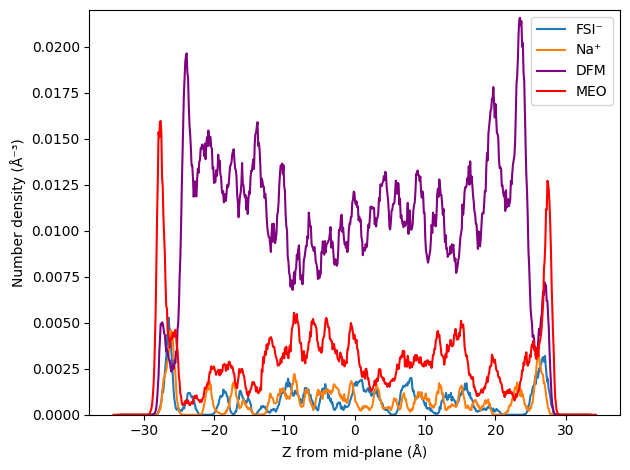

In [4]:
import numpy as np
import matplotlib.pyplot as plt

for fname, label in [("density_type4.txt", "FSI⁻"),
                     ("density_type2.txt", "Na⁺"),
                     ("density_type16.txt", "DFM"),
                     ("density_type7.txt", "MEO")]:
    
    data = np.loadtxt(fname)
    z, rho = data[:, 0], data[:, 1]

    # 색상 조건에 따라 지정
    if label == "MEO":
        plt.plot(z, rho, label=label, color='red')
    elif label == "DFM":
        plt.plot(z, rho, label=label, color='purple')
    else:
        plt.plot(z, rho, label=label)  # 기본 색상

plt.ylim(0, 0.022)  # 모든 그래프에서 동일한 y축 범위 설정
plt.xlabel("Z from mid-plane (Å)")
plt.ylabel("Number density (Å⁻³)")
plt.legend()
plt.tight_layout()
plt.show()

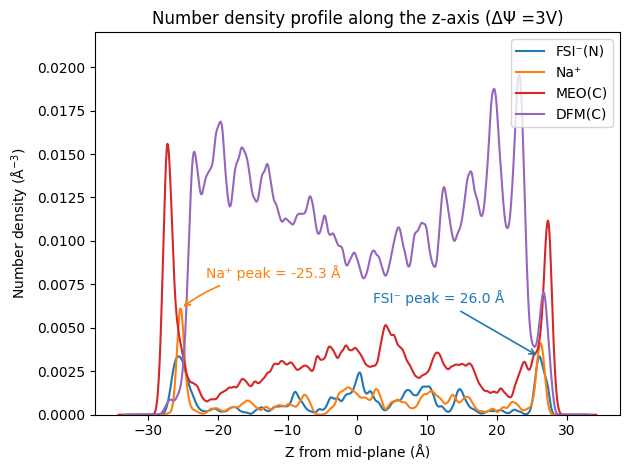

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# ===== 파라미터 =====
sigma        = 2                 # smoothing 강도
ymax         = 0.022             # y축 상한(원하면 None)
prominence   = 2e-4              # 피크 유의성
na_window    = (-30, -20)        # bottom slab 근처 Na⁺ 탐색 범위(Å)
fsi_top_win  = ( 20,  30)        # top slab 근처 FSI⁻ 탐색 범위(Å)

# 파일, 라벨, 색상 (필요시 파일명 바꾸세요)
series = [
    ("density_type4.txt", "FSI⁻(N)", "tab:blue"),
    ("density_type2.txt" , "Na⁺",  "tab:orange"),
    ("density_type7.txt" , "MEO(C)",  "tab:red"),
    ("density_type16.txt", "DFM(C)", "tab:purple"),
]

def find_peak_in_window(z, y, win, prom):
    m = (z >= win[0]) & (z <= win[1])
    if not np.any(m):
        return None
    zw, yw = z[m], y[m]
    peaks, _ = find_peaks(yw, prominence=prom)
    if len(peaks) == 0:
        return None
    i = peaks[np.argmax(yw[peaks])]
    return float(zw[i]), float(yw[i])

plt.figure(figsize=(6.4, 4.8))

z_ref = None
curves_s = {}

# --- 곡선 그리기 (스무딩 포함) ---
for fname, label, color in series:
    z, rho = np.loadtxt(fname, unpack=True)
    rho_s  = gaussian_filter1d(rho, sigma=sigma, mode="nearest")
    curves_s[label] = (z, rho_s, color)
    z_ref = z
    plt.plot(z, rho_s, label=label, color=color)

# --- Na⁺ bottom 피크 화살표 (위로 더 올림) ---
if "Na⁺" in curves_s:
    z, y, c = curves_s["Na⁺"]
    na_peak = find_peak_in_window(z, y, na_window, prominence)
    if na_peak is not None:
        zp, yp = na_peak
        plt.annotate(
            f"Na⁺ peak = {zp:.1f} Å",
            xy=(zp, yp), xycoords="data",
            xytext=(18, 20), textcoords="offset points",   # ← 여기만 높임
            arrowprops=dict(arrowstyle="->", lw=1.2, color=c,
                            connectionstyle="arc3,rad=0.15"),
            color=c, ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.9, edgecolor="none", pad=2.8)
        )


# --- FSI⁻ top 피크 화살표 ---
if "FSI⁻(N)" in curves_s:
    z, y, c = curves_s["FSI⁻(N)"]
    fsi_top = find_peak_in_window(z, y, fsi_top_win, prominence)
    if fsi_top is not None:
        zp, yp = fsi_top
        plt.annotate(f"FSI⁻ peak = {zp:.1f} Å",
                     xy=(zp, yp), xycoords="data",
                     xytext=(-25, 36), textcoords="offset points",
                     arrowprops=dict(arrowstyle="->", lw=1.2, color=c),
                     color=c, ha="right", va="bottom",
                     bbox=dict(facecolor="white", alpha=0.85, edgecolor="none", pad=2.5))

# 축/범례
if ymax is not None:
    plt.ylim(0, ymax)
plt.xlabel("Z from mid-plane (Å)")
plt.ylabel("Number density (Å$^{-3}$)")
plt.title("Number density profile along the z-axis (ΔΨ =3V)")
plt.legend(loc="upper right", frameon=True)
plt.tight_layout()
plt.show()

In [1]:
#Plot three diagrams

[INFO] Using frames with TIMESTEP in [8000000, 10000000]


Pass1 (z-range): 501it [00:11, 44.42it/s]
Pass2 (accumulate): 501it [00:10, 46.18it/s]


[INFO] saved density_type2_slabref.txt
[INFO] saved density_type4_slabref.txt
[INFO] saved density_type8_slabref.txt
[INFO] saved density_type16_slabref.txt
[INFO] saved peaks_meta.json


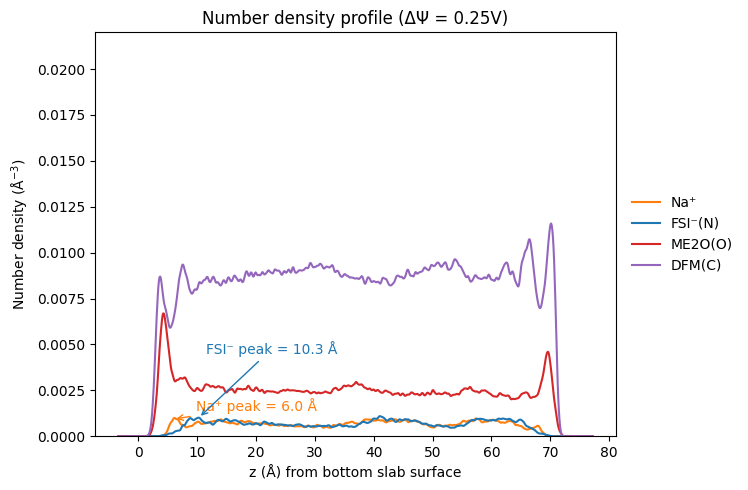

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
1D atomic density + peak detection (NaFSI:DFM:ME2O) — timestep windowed
- Same surface/binning as 2D, peaks quantized to 0.1 Å
- Uses only frames between 3.0 ns and 4.65 ns (configurable)
- Anion peak reference selectable: bottom | top | both
- Saves density_type{T}_slabref.txt and peaks_meta.json
- Plots species-wise curves (types in a species are summed)
"""

import json, math, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from typing import Sequence, Tuple, Dict, List

# ───────── User config ─────────
TRAJ = "analysis_nvt.lammpstrj"
ELECTRODE_TYPES_SAME = [1]     # 두 슬랩이 같은 type
BOTTOM_PCT = 95.0
TOP_PCT    = 5.0
DELTA_Z    = 0.1               # Å
SMOOTH_SIG = 2                 # bins

# --- timestep window 설정 ---
DT_FS = 1.0                    # fs per timestep (예: 1.0 fs)
TIME_WINDOW_NS = (8.0, 10.00)   # [ns] 구간
START_TS = None                # 정수 스텝으로 직접 지정하려면 값 설정
END_TS   = None

# --- 피크 탐색 윈도우 ---
WINDOW_NA        = (2.0, 6.0)   # Å from bottom (Na)
WINDOW_AN_TOP    = (2.0, 6.0)   # Å inward from top (FSI top-ref)
WINDOW_AN_BOTTOM = (2.0, 10.0)  # Å from bottom (FSI bottom-ref 기본창)
RIGHT_MIN_OFFSET = 0.2          # Na 피크 오른쪽으로 최소 오프셋(Å)
RIGHT_MAX_DELTA  = 10.0         # Na 피크에서 오른쪽 최대 탐색범위(Å)

EXTEND     = 5.0                # Å, global z-range padding
SORT_Z_ASC = True               # 저장/사용할 z-centers를 오름차순 정렬

# --- FSI 피크 기준 선택: "bottom" | "top" | "both"
ANION_PEAK_REF = "bottom"

# ★ 타입 정의 (프로젝트에 맞게 수정)
NA_TYPES    = [2]               # Na⁺
FSI_N_TYPES = [4]               # FSI⁻ 대표 원자 (N)
ME2O_TYPES  = [8]               # ME2O 대표 원자 (C)
DFM_TYPES   = [16]              # DFM 대표 원자 (C)

# 피크 찾기에 사용할 단일 대표 타입
NA_TYPE_REP    = NA_TYPES[0]
ANION_TYPE_REP = FSI_N_TYPES[0]

# 종별 묶음(플롯/범례/색상)
SPECIES: Dict[str, Dict] = {
    "Na⁺":     {"types": NA_TYPES,    "color": "tab:orange"},
    "FSI⁻(N)": {"types": FSI_N_TYPES, "color": "tab:blue"},
    "ME2O(O)": {"types": ME2O_TYPES,  "color": "tab:red"},
    "DFM(C)":  {"types": DFM_TYPES,   "color": "tab:purple"},
}
CATION_LABEL = "Na⁺"            # 2D와 메타 동기화용 라벨

# 이 스크립트가 저장할 타입들(중복 제거)
TYPES_TO_SAVE: List[int] = sorted({t for spec in SPECIES.values() for t in spec["types"]})

# ───────── Helpers ─────────
def qround(x: float, nd: int) -> float:
    return float(f"{x:.{nd}f}")

def parse_lammps_frame(frame_lines):
    data = {'bounds': {}, 'atoms': []}
    it = iter(frame_lines)
    try:
        while True:
            line = next(it).strip()
            if line.startswith("ITEM: BOX BOUNDS"):
                data['bounds']['x'] = list(map(float, next(it).split()))
                data['bounds']['y'] = list(map(float, next(it).split()))
                data['bounds']['z'] = list(map(float, next(it).split()))
            elif line.startswith("ITEM: ATOMS"):
                cols = line.split()[2:]
                idx_type = cols.index('type')
                coord = {}
                for d in ('x','y','z'):
                    for suf in ('','s','u'):
                        k = d+suf
                        if k in cols:
                            coord[d] = cols.index(k); break
                for ln in it:
                    sp = ln.split()
                    if len(sp) <= max(coord.values()): continue
                    data['atoms'].append((
                        int(float(sp[idx_type])),
                        float(sp[coord['x']]),
                        float(sp[coord['y']]),
                        float(sp[coord['z']])
                    ))
                break
    except StopIteration:
        pass
    if not data['bounds'] or not data['atoms']: return None
    a = np.array(data['atoms'], float)
    a[:,0] = a[:,0].astype(int)
    data['atoms'] = a
    return data

def read_lammps_frames_window(filename, start_ts=None, end_ts=None):
    """TIMESTEP이 [start_ts, end_ts]에 포함되는 프레임만 yield."""
    buf=[]; current_ts=None
    with open(filename) as f:
        for line in f:
            if line.startswith("ITEM: TIMESTEP"):
                # 이전 버퍼 flush (윈도우 포함 시)
                if buf and (current_ts is not None):
                    if ((start_ts is None or current_ts >= start_ts) and
                        (end_ts   is None or current_ts <= end_ts)):
                        yield buf
                # 새 버퍼 시작 + TIMESTEP 읽기
                buf=[line]
                ts_line = next(f)
                current_ts = int(ts_line.strip())
                buf.append(ts_line)
            else:
                buf.append(line)
        # 마지막 버퍼 처리
        if buf and (current_ts is not None):
            if ((start_ts is None or current_ts >= start_ts) and
                (end_ts   is None or current_ts <= end_ts)):
                yield buf

def bottom_top_surfaces_by_median_split(z_all: np.ndarray,
                                        bottom_pct: float,
                                        top_pct: float) -> Tuple[float,float]:
    zmid = np.median(z_all)
    lower = z_all[z_all <= zmid]
    upper = z_all[z_all >= zmid]
    if lower.size==0 or upper.size==0:
        order=np.argsort(z_all); half=len(order)//2
        m_lower=np.zeros_like(z_all,dtype=bool); m_lower[order[:half]]=True
        lower=z_all[m_lower]; upper=z_all[~m_lower]
    z_bot=np.percentile(lower, bottom_pct)
    z_top=np.percentile(upper,  top_pct)
    return float(z_bot), float(z_top)

# ───────── Pass 1: global z-range ─────────
def pass1_range(traj_file, atom_types: Sequence[int], start_ts=None, end_ts=None):
    zmin_g={t: np.inf for t in atom_types}
    zmax_g={t:-np.inf for t in atom_types}
    Hs=[]
    for fr in tqdm(read_lammps_frames_window(traj_file, start_ts, end_ts), desc="Pass1 (z-range)"):
        meta=parse_lammps_frame(fr)
        if meta is None: continue
        a=meta['atoms']; types=a[:,0].astype(int); z=a[:,3]
        z_elec = z[np.isin(types, ELECTRODE_TYPES_SAME)]
        if z_elec.size==0: continue
        z_bot,z_top = bottom_top_surfaces_by_median_split(z_elec, BOTTOM_PCT, TOP_PCT)
        Hs.append(z_top - z_bot)
        for t in atom_types:
            zr = z[types==t] - z_bot
            if zr.size==0: continue
            zmin_g[t]=min(zmin_g[t], float(np.min(zr)))
            zmax_g[t]=max(zmax_g[t], float(np.max(zr)))
    if not Hs: raise RuntimeError("No frames/surfaces found in selected window.")
    H_avg = float(np.mean(Hs))
    zlo = min(zmin_g.values()) - EXTEND
    zhi = max(zmax_g.values()) + EXTEND
    if not np.isfinite(zlo) or not np.isfinite(zhi) or zhi<=zlo:
        raise RuntimeError("Bad global z-range.")
    nbins=int(math.ceil((zhi-zlo)/DELTA_Z))
    edges=np.linspace(zlo, zhi+1e-9, nbins+1)
    centers=0.5*(edges[:-1]+edges[1:])
    return edges, centers, H_avg

# ───────── Pass 2: accumulate ─────────
def accumulate_profiles(traj_file, atom_types: Sequence[int], bin_edges, start_ts=None, end_ts=None):
    nbins=len(bin_edges)-1
    counts={t: np.zeros(nbins, dtype=np.int64) for t in atom_types}
    area_sum=0.0

    # anion(top-ref) 0–15 Å (옵션: top 또는 both일 때만 유효)
    if ANION_PEAK_REF in ("top", "both"):
        z_edges_t = np.linspace(0.0, 15.0+1e-9, int(math.ceil(15.0/DELTA_Z))+1)
        nb_t=len(z_edges_t)-1
        anion_top_counts=np.zeros(nb_t, dtype=np.int64)
    else:
        z_edges_t=None; anion_top_counts=None

    Hs=[]

    for fr in tqdm(read_lammps_frames_window(traj_file, start_ts, end_ts), desc="Pass2 (accumulate)"):
        meta=parse_lammps_frame(fr)
        if meta is None: continue
        a=meta['atoms']; types=a[:,0].astype(int); z=a[:,3]
        xlo,xhi=meta['bounds']['x']; ylo,yhi=meta['bounds']['y']
        Lx=xhi-xlo; Ly=yhi-ylo
        if Lx<=0 or Ly<=0: continue
        area_sum += (Lx*Ly)

        z_elec = z[np.isin(types, ELECTRODE_TYPES_SAME)]
        if z_elec.size==0: continue
        z_bot,z_top = bottom_top_surfaces_by_median_split(z_elec, BOTTOM_PCT, TOP_PCT)
        Hs.append(z_top - z_bot)

        for t in atom_types:
            zr = z[types==t] - z_bot
            if zr.size==0: continue
            h,_ = np.histogram(zr, bins=bin_edges)
            counts[t] += h

        if ANION_PEAK_REF in ("top", "both"):
            za = z[types==ANION_TYPE_REP]
            if za.size:
                rel_t = z_top - za
                m = (rel_t>=0.0) & (rel_t<=15.0)
                if np.any(m):
                    h,_ = np.histogram(rel_t[m], bins=z_edges_t)
                    anion_top_counts += h

    if area_sum<=0: raise RuntimeError("Zero XY area.")
    H_avg = float(np.mean(Hs)) if Hs else np.nan
    return counts, area_sum, (z_edges_t, anion_top_counts, H_avg)

# ───────── Main ─────────
if __name__ == "__main__":
    # 0) timestep window 계산/표시
    if START_TS is None or END_TS is None:
        steps_per_ns = 1_000_000.0 / float(DT_FS)  # 1 ns = 1e6 fs
        START_TS = int(round(TIME_WINDOW_NS[0] * steps_per_ns))
        END_TS   = int(round(TIME_WINDOW_NS[1] * steps_per_ns))
    print(f"[INFO] Using frames with TIMESTEP in [{START_TS}, {END_TS}]")

    # 1) bins
    bin_edges, z_axis, H_avg = pass1_range(TRAJ, TYPES_TO_SAVE, start_ts=START_TS, end_ts=END_TS)

    # 2) accumulate
    counts, area_sum, (z_edges_top, an_top_counts, H_avg2) = accumulate_profiles(
        TRAJ, TYPES_TO_SAVE, bin_edges, start_ts=START_TS, end_ts=END_TS
    )
    if np.isfinite(H_avg2): H_avg = H_avg2

    # 3) densities (Å^-3)
    dens   = {t: counts[t] / (area_sum * DELTA_Z) for t in TYPES_TO_SAVE}
    dens_s = {t: gaussian_filter1d(dens[t].astype(float), sigma=SMOOTH_SIG, mode="nearest")
              for t in TYPES_TO_SAVE}

    # anion(top-ref) 스무딩(옵션)
    if ANION_PEAK_REF in ("top", "both") and an_top_counts is not None:
        an_top_s = gaussian_filter1d(an_top_counts.astype(float), sigma=SMOOTH_SIG, mode="nearest")
    else:
        an_top_s = None

    # 4) peaks (no sub-bin refine → 1D/2D 완전 일치)
    # Na (bottom-ref)
    m_na = (z_axis>=WINDOW_NA[0]) & (z_axis<=WINDOW_NA[1])
    idx_na = int(np.argmax(dens_s.get(NA_TYPE_REP, np.zeros_like(z_axis))[m_na])) if np.any(m_na) \
             else int(np.argmax(dens_s[NA_TYPE_REP]))
    z_na_raw = float(z_axis[m_na][idx_na]) if np.any(m_na) else float(z_axis[idx_na])

    # FSI (bottom-ref: Na 오른쪽 탐색)
    z_an_bottom_raw = None
    if ANION_PEAK_REF in ("bottom", "both"):
        right_lo = max(WINDOW_AN_BOTTOM[0], z_na_raw + RIGHT_MIN_OFFSET)
        right_hi = min(z_axis[-1], z_na_raw + RIGHT_MAX_DELTA)
        m_an_b = (z_axis >= right_lo) & (z_axis <= right_hi)
        an_curve = dens_s.get(ANION_TYPE_REP, np.zeros_like(z_axis))
        if np.any(m_an_b) and np.any(an_curve[m_an_b] > 0):
            idx_an_b = int(np.argmax(an_curve[m_an_b]))
            z_an_bottom_raw = float(z_axis[m_an_b][idx_an_b])

    # FSI (top-ref → bottom 좌표로 환산)
    z_an_top_raw = None
    if ANION_PEAK_REF in ("top", "both") and an_top_s is not None and z_edges_top is not None:
        z_axis_top = 0.5*(z_edges_top[:-1]+z_edges_top[1:])
        m_an_t = (z_axis_top>=WINDOW_AN_TOP[0]) & (z_axis_top<=WINDOW_AN_TOP[1])
        idx_an_t = int(np.argmax(an_top_s[m_an_t])) if np.any(m_an_t) else int(np.argmax(an_top_s))
        z_top_from_top_raw = float(z_axis_top[m_an_t][idx_an_t]) if np.any(m_an_t) else float(z_axis_top[idx_an_t])
        z_an_top_raw = H_avg - z_top_from_top_raw

    # 5) quantize (0.1 Å)
    z_bot_peak  = qround(z_na_raw, 1)
    z_bulk      = qround(H_avg/2.0, 2)
    z_an_bottom = qround(z_an_bottom_raw, 1) if z_an_bottom_raw is not None else None
    z_an_top    = qround(z_an_top_raw, 1)    if z_an_top_raw    is not None else None

    # 6) save 1D per type
    for t in TYPES_TO_SAVE:
        out=f"density_type{t}_slabref.txt"
        header="# z_from_bottom(Å)  number_density(Å^-3)"
        np.savetxt(out, np.column_stack([z_axis, dens[t]]), header=header, fmt="%.6e")
        print(f"[INFO] saved {out}")

    # 7) save meta (정렬된 z-centers)
    z_centers_used = [z for z in [z_bot_peak, z_bulk, (z_an_bottom if ANION_PEAK_REF in ("bottom","both") and z_an_bottom is not None else z_an_top)] if z is not None]
    if SORT_Z_ASC:
        z_centers_used = sorted(z_centers_used)

    meta = {
        "bot_peak_Na": z_bot_peak,
        "bulk_mid": z_bulk,
        "H": qround(H_avg, 2),
        "anion_peak_ref": ANION_PEAK_REF,
        "cation_label": CATION_LABEL,
        "z_centers_used": z_centers_used,
        "delta_z": DELTA_Z,
        "smooth_sigma_bins": SMOOTH_SIG,
        "na_window": list(WINDOW_NA),
        "anion_window_bottom": list(WINDOW_AN_BOTTOM),
        "anion_window_top": list(WINDOW_AN_TOP),
        "electrode_types_same": ELECTRODE_TYPES_SAME,
        "percentiles": {"bottom_pct": BOTTOM_PCT, "top_pct": TOP_PCT},
        "timestep_window": {"start_ts": START_TS, "end_ts": END_TS},
        "extra_slices": [8.5] 
    }
    if z_an_bottom is not None:
        meta["bot_peak_FSI"] = z_an_bottom
    if z_an_top is not None:
        meta["top_peak_FSI"] = z_an_top

    with open("peaks_meta.json","w",encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    print("[INFO] saved peaks_meta.json")

    # 8) plot species-wise (types in a species are summed)
    plt.figure(figsize=(7.6,5.0))

    def y_at(z0: float, zax: np.ndarray, ycurve: np.ndarray) -> float:
        i = int(np.argmin(np.abs(zax - z0)))
        return float(ycurve[i])

    for name, spec in SPECIES.items():
        ysum = np.zeros_like(z_axis, dtype=float)
        for t in spec["types"]:
            if t in dens_s:
                ysum += dens_s[t]
        plt.plot(z_axis, ysum, label=name, color=spec["color"])

    # annotate peaks
    y_na_curve = np.zeros_like(z_axis, dtype=float)
    for t in SPECIES["Na⁺"]["types"]:
        if t in dens_s: y_na_curve += dens_s[t]
    plt.annotate(f"Na⁺ peak = {z_bot_peak:.1f} Å",
                 xy=(z_bot_peak, y_at(z_bot_peak, z_axis, y_na_curve)),
                 xytext=(16, 6), textcoords="offset points",
                 arrowprops=dict(arrowstyle="->", lw=1.0, color=SPECIES["Na⁺"]["color"]),
                 color=SPECIES["Na⁺"]["color"])

    y_fsi_curve = np.zeros_like(z_axis, dtype=float)
    for t in SPECIES["FSI⁻(N)"]["types"]:
        if t in dens_s: y_fsi_curve += dens_s[t]
    # 표시 우선순위: bottom-ref 값이 있으면 그걸 표시, 없으면 top-ref 표시
    z_show = z_an_bottom if z_an_bottom is not None else z_an_top
    if z_show is not None:
        plt.annotate(f"FSI⁻ peak = {z_show:.1f} Å",
                     xy=(z_show, y_at(z_show, z_axis, y_fsi_curve)),
                     xytext=(100, 46), textcoords="offset points", ha="right",
                     arrowprops=dict(arrowstyle="->", lw=1.0, color=SPECIES["FSI⁻(N)"]["color"]),
                     color=SPECIES["FSI⁻(N)"]["color"])

    plt.ylim(0, 0.022)
    plt.xlabel("z (Å) from bottom slab surface")
    plt.ylabel("Number density (Å$^{-3}$)")
    plt.title(f"Number density profile (ΔΨ = 0.25V)")
    plt.legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        frameon=False
    )
    plt.tight_layout()
    plt.show()

Pass1 (z-range): 662it [00:13, 50.13it/s]
Pass2 (accumulate): 662it [00:12, 51.13it/s]


[8000000–10645000] Total number of Na atoms up to 20.0 Å = 7.85


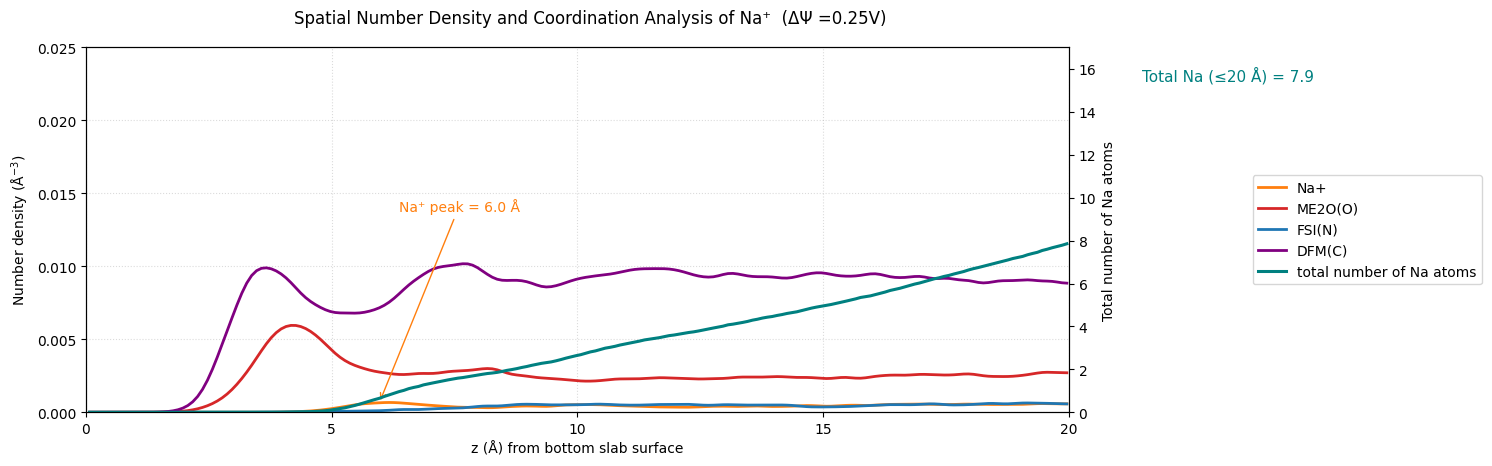

>>> saved: density_profiles.csv, density_profiles_meta.json


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
NaFSI : DFM : ME2O
Single panel:
- Left y: 1D number density by group (bottom-referenced, z-only)
- Right y: cumulative total Na up to z (∫ρ_Na(z) dz × <Area>)
"""

import json, math, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import MultipleLocator
from typing import Sequence, Tuple, Dict, List

# ───────── User config ─────────
TRAJ = "analysis_nvt.lammpstrj"
ELECTRODE_TYPES_SAME = [1]

# Surface detection & binning
BOTTOM_PCT = 95.0
TOP_PCT    = 5.0
DELTA_Z    = 0.1
SMOOTH_SIG = 2
EXTEND     = 5.0

# ----- Atom types (from your Masses table) -----
NA_TYPE     = 2                 # Na+
FSI_N_TYPE  = 4                 # NBT  (useful marker for FSI)
FSI_O_TYPE  = 5                 # OBT  (for CN, if needed)
ME2O_C_TYPE = [7, 9]           # C8H0, C8H2  -> density group
ME2O_O_TYPE  = 8                # O8H1 (for CN, if needed)
DFM_C_TYPE   = 16               # C800 -> density group (DFM carbon)
DFM_F_TYPES  = [17, 18]         # F801, F802 (for CN, optional)

# ----- Density groups (sum of LAMMPS types) -----
DENSITY_GROUPS: Dict[str, List[int]] = {
    "Na+":      [NA_TYPE],
    "ME2O(O)":  [ME2O_O_TYPE],
    "FSI(N)":   [FSI_N_TYPE],
    "DFM(C)":   [DFM_C_TYPE],
}

# Colors for density curves
COLORS = {
    "Na+":     "tab:orange",
    "ME2O(O)": "tab:red",
    "FSI(N)":  "tab:blue",
    "DFM(C)":  "purple",
}

# Peak window (Na only)
WINDOW_NA = (2.0, 6.0)

# CN (kept here if you later want to reuse; not plotted in this script)
Z_MAX_VIEW = 20.0
RCUT_CN    = {"Na–ME2O(O)": 3.30, "Na–FSI(O)": 3.50, "Na–DFM(F)": 3.30}
CN_METRIC  = "z"   # "3d" or "z"
YLIM_DENSITY = (0.0, 0.025)   # None → auto
YLIM_NA_TOT  = (0, 17)           # None → auto

# Timestep window (inclusive)
START_TS = 8_000_000
END_TS   = 10_645_000

# ───────── Helpers ─────────
def qround(x: float, nd: int) -> float:
    return float(f"{x:.{nd}f}")

def parse_lammps_frame(frame_lines):
    """Parse a single LAMMPS dump frame."""
    data={'bounds':{}, 'atoms':[]}
    it=iter(frame_lines)
    try:
        while True:
            line=next(it).strip()
            if line.startswith("ITEM: BOX BOUNDS"):
                data['bounds']['x']=list(map(float, next(it).split()))
                data['bounds']['y']=list(map(float, next(it).split()))
                data['bounds']['z']=list(map(float, next(it).split()))
            elif line.startswith("ITEM: ATOMS"):
                cols=line.split()[2:]
                t_idx=cols.index('type')
                cidx={}
                for d in ('x','y','z'):
                    for suf in ('','s','u'):
                        k=d+suf
                        if k in cols: cidx[d]=cols.index(k); break
                for ln in it:
                    sp=ln.split()
                    if len(sp)<=max(cidx.values()): continue
                    data['atoms'].append((
                        int(float(sp[t_idx])),
                        float(sp[cidx['x']]),
                        float(sp[cidx['y']]),
                        float(sp[cidx['z']]),
                    ))
                break
    except StopIteration:
        pass
    if not data['bounds'] or not data['atoms']: return None
    a=np.array(data['atoms'], float); a[:,0]=a[:,0].astype(int); data['atoms']=a
    return data

def read_lammps_frames(filename, start_ts=None, end_ts=None):
    """Yield frames whose TIMESTEP is within [start_ts, end_ts]."""
    buf=[]; current_ts=None
    with open(filename) as f:
        for line in f:
            if line.startswith("ITEM: TIMESTEP"):
                if buf and current_ts is not None:
                    if (start_ts is None or current_ts >= start_ts) and (end_ts is None or current_ts <= end_ts):
                        yield buf
                buf=[line]
                ts_line=next(f)
                current_ts=int(ts_line.strip())
                buf.append(ts_line)
            else:
                buf.append(line)
        if buf and current_ts is not None:
            if (start_ts is None or current_ts >= start_ts) and (end_ts is None or current_ts <= end_ts):
                yield buf

def bottom_top_surfaces_by_median_split(z_all: np.ndarray, bottom_pct: float, top_pct: float) -> Tuple[float,float]:
    zmid=np.median(z_all)
    lower=z_all[z_all<=zmid]
    upper=z_all[z_all>=zmid]
    if lower.size==0 or upper.size==0:
        order=np.argsort(z_all); half=len(order)//2
        m_lower=np.zeros_like(z_all,dtype=bool); m_lower[order[:half]]=True
        lower=z_all[m_lower]; upper=z_all[~m_lower]
    z_bot=float(np.percentile(lower, bottom_pct))
    z_top=float(np.percentile(upper,  top_pct))
    return z_bot, z_top

def minimum_image(d, L):
    return d - L*np.round(d/L)

# Convenience
def _all_raw_types(groups: Dict[str, List[int]]) -> List[int]:
    s=set()
    for lst in groups.values(): s.update(lst)
    return sorted(s)

# ───────── Pass 1 ─────────
def pass1_range(traj_file, groups: Dict[str, List[int]], start_ts=None, end_ts=None):
    atom_types = _all_raw_types(groups)
    zmin_g={t: np.inf for t in atom_types}
    zmax_g={t:-np.inf for t in atom_types}
    Hs=[]
    for fr in tqdm(read_lammps_frames(traj_file, start_ts, end_ts), desc="Pass1 (z-range)"):
        meta=parse_lammps_frame(fr)
        if meta is None: continue
        a=meta['atoms']; types=a[:,0].astype(int); z=a[:,3]
        z_elec=z[np.isin(types, ELECTRODE_TYPES_SAME)]
        if z_elec.size==0: continue
        z_bot,z_top=bottom_top_surfaces_by_median_split(z_elec, BOTTOM_PCT, TOP_PCT)
        Hs.append(z_top-z_bot)
        zr=z - z_bot
        for t in atom_types:
            m=(types==t)
            if not np.any(m): continue
            zmin_g[t]=min(zmin_g[t], float(np.min(zr[m])))
            zmax_g[t]=max(zmax_g[t], float(np.max(zr[m])))
    if not Hs: raise RuntimeError("No frames/surfaces found in selected timestep window.")
    H_avg=float(np.mean(Hs))
    zlo=min(zmin_g.values())-EXTEND; zhi=max(zmax_g.values())+EXTEND
    nbins=int(math.ceil((zhi-zlo)/DELTA_Z))
    edges=np.linspace(zlo, zhi+1e-9, nbins+1)
    centers=0.5*(edges[:-1]+edges[1:])
    return edges, centers, H_avg

# ───────── Pass 2 ─────────
def accumulate_profiles(traj_file, groups: Dict[str, List[int]], bin_edges, start_ts=None, end_ts=None):
    nbins=len(bin_edges)-1
    raw_ids = _all_raw_types(groups)
    counts_raw={t: np.zeros(nbins, dtype=np.int64) for t in raw_ids}
    area_sum=0.0; Hs=[]; nframes_used=0
    for fr in tqdm(read_lammps_frames(traj_file, start_ts, end_ts), desc="Pass2 (accumulate)"):
        meta=parse_lammps_frame(fr)
        if meta is None: continue
        a=meta['atoms']; types=a[:,0].astype(int); z=a[:,3]
        xlo,xhi=meta['bounds']['x']; ylo,yhi=meta['bounds']['y']
        Lx=xhi-xlo; Ly=yhi-ylo
        if Lx<=0 or Ly<=0: continue
        z_elec=z[np.isin(types, ELECTRODE_TYPES_SAME)]
        if z_elec.size==0: continue
        nframes_used+=1; area_sum += (Lx*Ly)
        z_bot,z_top=bottom_top_surfaces_by_median_split(z_elec, BOTTOM_PCT, TOP_PCT)
        Hs.append(z_top-z_bot)
        zr=z - z_bot
        for t in raw_ids:
            m=(types==t)
            if not np.any(m): continue
            h,_=np.histogram(zr[m], bins=bin_edges)
            counts_raw[t]+=h
    if area_sum<=0 or nframes_used==0: raise RuntimeError("Zero area or no valid frames in selected timestep window.")
    H_avg=float(np.mean(Hs)) if Hs else np.nan
    # Group sums
    counts_group = {g: np.zeros(nbins, dtype=np.int64) for g in groups}
    for g, tids in groups.items():
        for t in tids:
            if t in counts_raw:
                counts_group[g] += counts_raw[t]
    return counts_group, area_sum, H_avg, nframes_used

# (CN helper retained; not used in plot)
def cn_profile_vs_z(traj_file, A_types: List[int], B_types: List[int], rcut, zmax=20.0, dz=0.1, metric="3d", start_ts=None, end_ts=None):
    nbins=int(math.ceil(zmax/dz))
    z_edges=np.linspace(0.0, zmax+1e-9, nbins+1)
    z_cent=0.5*(z_edges[:-1]+z_edges[1:])
    neigh_sum=np.zeros(nbins, float)
    a_count=np.zeros(nbins, int)
    if not A_types or not B_types:
        return z_cent, np.zeros_like(z_cent), np.zeros_like(z_cent)
    for fr in read_lammps_frames(traj_file, start_ts, end_ts):
        meta=parse_lammps_frame(fr)
        if meta is None: continue
        a=meta['atoms']; types=a[:,0].astype(int)
        x,y,z=a[:,1],a[:,2],a[:,3]
        (xlo,xhi),(ylo,yhi),(zlo,zhi)=meta['bounds']['x'],meta['bounds']['y'],meta['bounds']['z']
        Lx, Ly, Lz=xhi-xlo, yhi-ylo, zhi-zlo
        z_elec=z[np.isin(types, ELECTRODE_TYPES_SAME)]
        if z_elec.size==0: continue
        z_bot,_=bottom_top_surfaces_by_median_split(z_elec, BOTTOM_PCT, TOP_PCT)
        z_rel=z-z_bot
        mA=np.isin(types, A_types) & (z_rel>=0.0) & (z_rel<=zmax)
        mB=np.isin(types, B_types)
        if not np.any(mA) or not np.any(mB): continue
        A=a[mA]; zA=z_rel[mA]; B=a[mB]
        if metric=="z":
            for (_,_,az), zpos in zip(A[:,1:4], zA):
                dzv=minimum_image(B[:,3]-az, Lz)
                nbh=int(np.count_nonzero(np.abs(dzv)<=rcut))
                k=int(np.floor(zpos/dz))
                if 0<=k<nbins: neigh_sum[k]+=nbh; a_count[k]+=1
        else:
            rc2=rcut*rcut
            for (ax,ay,az), zpos in zip(A[:,1:4], zA):
                dx=minimum_image(B[:,1]-ax, Lx)
                dy=minimum_image(B[:,2]-ay, Ly)
                dzv=minimum_image(B[:,3]-az, Lz)
                rr2=dx*dx+dy*dy+dzv*dzv
                nbh=int(np.count_nonzero(rr2<=rc2))
                k=int(np.floor(zpos/dz))
                if 0<=k<nbins: neigh_sum[k]+=nbh; a_count[k]+=1
    with np.errstate(divide='ignore', invalid='invalid'):
        cn_bin=np.where(a_count>0, neigh_sum/a_count, 0.0)
    cum_neigh=np.cumsum(neigh_sum); cum_A=np.cumsum(a_count)
    with np.errstate(divide='ignore', invalid='invalid'):
        cn_cum=np.where(cum_A>0, cum_neigh/cum_A, 0.0)
    return z_cent, cn_bin, cn_cum

# ───────── Main ─────────
if __name__=="__main__":
    # Binning & accumulation (timestep-filtered)
    bin_edges, z_axis, H_avg = pass1_range(TRAJ, DENSITY_GROUPS, start_ts=START_TS, end_ts=END_TS)
    counts_group, area_sum, H_avg2, nframes_used = accumulate_profiles(
        TRAJ, DENSITY_GROUPS, bin_edges, start_ts=START_TS, end_ts=END_TS
    )
    if np.isfinite(H_avg2): H_avg=H_avg2

    # Densities per group
    dens = {g: counts_group[g] / (area_sum * DELTA_Z) for g in DENSITY_GROUPS}
    dens_s = {g: gaussian_filter1d(dens[g].astype(float), sigma=SMOOTH_SIG, mode="nearest")
              for g in DENSITY_GROUPS}

    # Na peak
    m_plot = (z_axis >= 0.0) & (z_axis <= Z_MAX_VIEW)
    m_na=(z_axis>=WINDOW_NA[0]) & (z_axis<=WINDOW_NA[1])
    if np.any(m_na) and np.any(dens_s["Na+"][m_na]):
        local_idx = int(np.argmax(dens_s["Na+"][m_na]))
        z_bot_peak=float(z_axis[m_na][local_idx])
    else:
        z_bot_peak=float(z_axis[np.argmax(dens_s["Na+"])])

    # Cumulative Na total = ∫ρ_Na(z) dz × <Area>
    cum_na_per_area = np.cumsum(dens["Na+"]) * DELTA_Z
    area_avg = area_sum / nframes_used
    cum_na_total = cum_na_per_area * area_avg
    total_na_up_to_zmax = float(cum_na_total[m_plot][-1])
    print(f"[{START_TS}–{END_TS}] Total number of Na atoms up to {Z_MAX_VIEW:.1f} Å = {total_na_up_to_zmax:.2f}")

    # ── Plot ──
    fig, ax = plt.subplots(figsize=(12.6, 4.8))
    fig.subplots_adjust(left=0.10, right=0.88, bottom=0.14, top=0.90)

    # Densities
    for g in ["Na+", "ME2O(O)", "FSI(N)", "DFM(C)"]:
        if g in dens_s:
            ax.plot(z_axis[m_plot], dens_s[g][m_plot], lw=2.0, label=g, color=COLORS.get(g, None))
    ax.set_xlim(0.0, Z_MAX_VIEW)
    if YLIM_DENSITY is not None: ax.set_ylim(*YLIM_DENSITY)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlabel("z (Å) from bottom slab surface")
    ax.set_ylabel("Number density (Å$^{-3}$)")
    ax.grid(True, ls=":", alpha=0.45)

    # Na peak annotation
    if 0.0 <= z_bot_peak <= Z_MAX_VIEW:
        y_na = float(dens_s["Na+"][np.argmin(np.abs(z_axis - z_bot_peak))])
        ax.annotate(f"Na⁺ peak = {z_bot_peak:.1f} Å",
                    xy=(z_bot_peak, y_na),
                    xytext=(14,138), textcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=1.0, color=COLORS["Na+"]),
                    color=COLORS["Na+"])

    # Cumulative Na (right y)
    ax_na = ax.twinx()
    ax_na.plot(z_axis[m_plot], cum_na_total[m_plot], color="teal", lw=2.2, label="total number of Na atoms")
    if YLIM_NA_TOT is not None: ax_na.set_ylim(*YLIM_NA_TOT)
    ax_na.set_ylabel("Total number of Na atoms", color="k")
    ax_na.text(1.25, 0.95, f"Total Na (≤{Z_MAX_VIEW:.0f} Å) = {total_na_up_to_zmax:.1f}",
               transform=ax_na.transAxes, ha='right', va='top',
               fontsize=11, color="teal",
               bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Legend
    h_d, l_d = ax.get_legend_handles_labels()
    h_na, l_na = ax_na.get_legend_handles_labels()
    ax.legend(h_d + h_na, l_d + l_na, loc="center left",
              bbox_to_anchor=(1.18, 0.5), frameon=True)

    fig.suptitle("Spatial Number Density and Coordination Analysis of Na⁺  (ΔΨ =0.25V)", y=0.98)
    plt.show()

    # ── CSV로 내보내기: 이 파일 하나로 재현 가능하도록 스무딩값 포함 ──
import pandas as pd

# 저장 구간: m_plot이 True인 z만 저장(그림과 동일한 x축 구간)
z_out = z_axis[m_plot]

# 그래프에 쓰인 스무딩 밀도와 누적 Na
out = {
    "z_A": z_out,
    "Na+_density_smooth": dens_s["Na+"][m_plot],
    "ME2O(O)_density_smooth": dens_s["ME2O(O)"][m_plot],
    "FSI(N)_density_smooth": dens_s["FSI(N)"][m_plot],
    "DFM(C)_density_smooth": dens_s["DFM(C)"][m_plot],
    "Cumulative_Na": cum_na_total[m_plot],
}

# 재현에 필요한 메타 정보도 같이 저장(두 번째 파일)
meta = {
    "TRAJ": TRAJ,
    "START_TS": START_TS,
    "END_TS": END_TS,
    "DELTA_Z": DELTA_Z,
    "SMOOTH_SIG": SMOOTH_SIG,
    "Z_MAX_VIEW": Z_MAX_VIEW,
    "BOTTOM_PCT": BOTTOM_PCT,
    "TOP_PCT": TOP_PCT,
    "AREA_AVG": float(area_avg),
}

pd.DataFrame(out).to_csv("density_profiles.csv", index=False, float_format="%.6f")
with open("density_profiles_meta.json", "w") as f:
    import json; json.dump(meta, f, indent=2)
print(">>> saved: density_profiles.csv, density_profiles_meta.json")

Pass1 (z-range): 501it [00:10, 46.18it/s]
Pass2 (accumulate): 501it [00:10, 45.59it/s]


[8000000–10000000] Total number of Na atoms up to 20.0 Å = 12.34


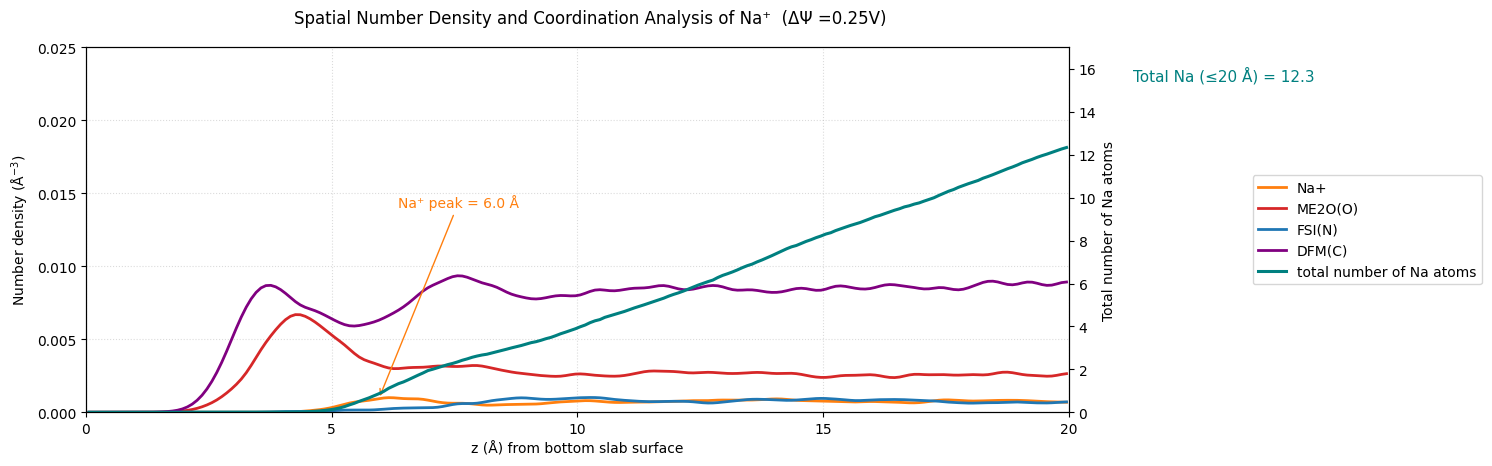

>>> saved: density_profiles.csv, density_profiles_meta.json


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
NaFSI : DFM : ME2O
Single panel:
- Left y: 1D number density by group (bottom-referenced, z-only)
- Right y: cumulative total Na up to z (∫ρ_Na(z) dz × <Area>)
"""

import json, math, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import MultipleLocator
from typing import Sequence, Tuple, Dict, List

# ───────── User config ─────────
TRAJ = "analysis_nvt.lammpstrj"
ELECTRODE_TYPES_SAME = [1]

# Surface detection & binning
BOTTOM_PCT = 95.0
TOP_PCT    = 5.0
DELTA_Z    = 0.1
SMOOTH_SIG = 2
EXTEND     = 5.0

# ----- Atom types (from your Masses table) -----
NA_TYPE     = 2                 # Na+
FSI_N_TYPE  = 4                 # NBT  (useful marker for FSI)
FSI_O_TYPE  = 5                 # OBT  (for CN, if needed)
ME2O_C_TYPE = [7, 9]           # C8H0, C8H2  -> density group
ME2O_O_TYPE  = 8                # O8H1 (for CN, if needed)
DFM_C_TYPE   = 16               # C800 -> density group (DFM carbon)
DFM_F_TYPES  = [17, 18]         # F801, F802 (for CN, optional)

# ----- Density groups (sum of LAMMPS types) -----
DENSITY_GROUPS: Dict[str, List[int]] = {
    "Na+":      [NA_TYPE],
    "ME2O(O)":  [ME2O_O_TYPE],
    "FSI(N)":   [FSI_N_TYPE],
    "DFM(C)":   [DFM_C_TYPE],
}

# Colors for density curves
COLORS = {
    "Na+":     "tab:orange",
    "ME2O(O)": "tab:red",
    "FSI(N)":  "tab:blue",
    "DFM(C)":  "purple",
}

# Peak window (Na only)
WINDOW_NA = (2.0, 6.0)

# CN (kept here if you later want to reuse; not plotted in this script)
Z_MAX_VIEW = 20.0
RCUT_CN    = {"Na–ME2O(O)": 3.30, "Na–FSI(O)": 3.50, "Na–DFM(F)": 3.30}
CN_METRIC  = "z"   # "3d" or "z"
YLIM_DENSITY = (0.0, 0.025)   # None → auto
YLIM_NA_TOT  = (0, 17)           # None → auto

# Timestep window (inclusive)
START_TS = 8_000_000
END_TS   = 10_000_000

# ───────── Helpers ─────────
def qround(x: float, nd: int) -> float:
    return float(f"{x:.{nd}f}")

def parse_lammps_frame(frame_lines):
    """Parse a single LAMMPS dump frame."""
    data={'bounds':{}, 'atoms':[]}
    it=iter(frame_lines)
    try:
        while True:
            line=next(it).strip()
            if line.startswith("ITEM: BOX BOUNDS"):
                data['bounds']['x']=list(map(float, next(it).split()))
                data['bounds']['y']=list(map(float, next(it).split()))
                data['bounds']['z']=list(map(float, next(it).split()))
            elif line.startswith("ITEM: ATOMS"):
                cols=line.split()[2:]
                t_idx=cols.index('type')
                cidx={}
                for d in ('x','y','z'):
                    for suf in ('','s','u'):
                        k=d+suf
                        if k in cols: cidx[d]=cols.index(k); break
                for ln in it:
                    sp=ln.split()
                    if len(sp)<=max(cidx.values()): continue
                    data['atoms'].append((
                        int(float(sp[t_idx])),
                        float(sp[cidx['x']]),
                        float(sp[cidx['y']]),
                        float(sp[cidx['z']]),
                    ))
                break
    except StopIteration:
        pass
    if not data['bounds'] or not data['atoms']: return None
    a=np.array(data['atoms'], float); a[:,0]=a[:,0].astype(int); data['atoms']=a
    return data

def read_lammps_frames(filename, start_ts=None, end_ts=None):
    """Yield frames whose TIMESTEP is within [start_ts, end_ts]."""
    buf=[]; current_ts=None
    with open(filename) as f:
        for line in f:
            if line.startswith("ITEM: TIMESTEP"):
                if buf and current_ts is not None:
                    if (start_ts is None or current_ts >= start_ts) and (end_ts is None or current_ts <= end_ts):
                        yield buf
                buf=[line]
                ts_line=next(f)
                current_ts=int(ts_line.strip())
                buf.append(ts_line)
            else:
                buf.append(line)
        if buf and current_ts is not None:
            if (start_ts is None or current_ts >= start_ts) and (end_ts is None or current_ts <= end_ts):
                yield buf

def bottom_top_surfaces_by_median_split(z_all: np.ndarray, bottom_pct: float, top_pct: float) -> Tuple[float,float]:
    zmid=np.median(z_all)
    lower=z_all[z_all<=zmid]
    upper=z_all[z_all>=zmid]
    if lower.size==0 or upper.size==0:
        order=np.argsort(z_all); half=len(order)//2
        m_lower=np.zeros_like(z_all,dtype=bool); m_lower[order[:half]]=True
        lower=z_all[m_lower]; upper=z_all[~m_lower]
    z_bot=float(np.percentile(lower, bottom_pct))
    z_top=float(np.percentile(upper,  top_pct))
    return z_bot, z_top

def minimum_image(d, L):
    return d - L*np.round(d/L)

# Convenience
def _all_raw_types(groups: Dict[str, List[int]]) -> List[int]:
    s=set()
    for lst in groups.values(): s.update(lst)
    return sorted(s)

# ───────── Pass 1 ─────────
def pass1_range(traj_file, groups: Dict[str, List[int]], start_ts=None, end_ts=None):
    atom_types = _all_raw_types(groups)
    zmin_g={t: np.inf for t in atom_types}
    zmax_g={t:-np.inf for t in atom_types}
    Hs=[]
    for fr in tqdm(read_lammps_frames(traj_file, start_ts, end_ts), desc="Pass1 (z-range)"):
        meta=parse_lammps_frame(fr)
        if meta is None: continue
        a=meta['atoms']; types=a[:,0].astype(int); z=a[:,3]
        z_elec=z[np.isin(types, ELECTRODE_TYPES_SAME)]
        if z_elec.size==0: continue
        z_bot,z_top=bottom_top_surfaces_by_median_split(z_elec, BOTTOM_PCT, TOP_PCT)
        Hs.append(z_top-z_bot)
        zr=z - z_bot
        for t in atom_types:
            m=(types==t)
            if not np.any(m): continue
            zmin_g[t]=min(zmin_g[t], float(np.min(zr[m])))
            zmax_g[t]=max(zmax_g[t], float(np.max(zr[m])))
    if not Hs: raise RuntimeError("No frames/surfaces found in selected timestep window.")
    H_avg=float(np.mean(Hs))
    zlo=min(zmin_g.values())-EXTEND; zhi=max(zmax_g.values())+EXTEND
    nbins=int(math.ceil((zhi-zlo)/DELTA_Z))
    edges=np.linspace(zlo, zhi+1e-9, nbins+1)
    centers=0.5*(edges[:-1]+edges[1:])
    return edges, centers, H_avg

# ───────── Pass 2 ─────────
def accumulate_profiles(traj_file, groups: Dict[str, List[int]], bin_edges, start_ts=None, end_ts=None):
    nbins=len(bin_edges)-1
    raw_ids = _all_raw_types(groups)
    counts_raw={t: np.zeros(nbins, dtype=np.int64) for t in raw_ids}
    area_sum=0.0; Hs=[]; nframes_used=0
    for fr in tqdm(read_lammps_frames(traj_file, start_ts, end_ts), desc="Pass2 (accumulate)"):
        meta=parse_lammps_frame(fr)
        if meta is None: continue
        a=meta['atoms']; types=a[:,0].astype(int); z=a[:,3]
        xlo,xhi=meta['bounds']['x']; ylo,yhi=meta['bounds']['y']
        Lx=xhi-xlo; Ly=yhi-ylo
        if Lx<=0 or Ly<=0: continue
        z_elec=z[np.isin(types, ELECTRODE_TYPES_SAME)]
        if z_elec.size==0: continue
        nframes_used+=1; area_sum += (Lx*Ly)
        z_bot,z_top=bottom_top_surfaces_by_median_split(z_elec, BOTTOM_PCT, TOP_PCT)
        Hs.append(z_top-z_bot)
        zr=z - z_bot
        for t in raw_ids:
            m=(types==t)
            if not np.any(m): continue
            h,_=np.histogram(zr[m], bins=bin_edges)
            counts_raw[t]+=h
    if area_sum<=0 or nframes_used==0: raise RuntimeError("Zero area or no valid frames in selected timestep window.")
    H_avg=float(np.mean(Hs)) if Hs else np.nan
    # Group sums
    counts_group = {g: np.zeros(nbins, dtype=np.int64) for g in groups}
    for g, tids in groups.items():
        for t in tids:
            if t in counts_raw:
                counts_group[g] += counts_raw[t]
    return counts_group, area_sum, H_avg, nframes_used

# (CN helper retained; not used in plot)
def cn_profile_vs_z(traj_file, A_types: List[int], B_types: List[int], rcut, zmax=20.0, dz=0.1, metric="3d", start_ts=None, end_ts=None):
    nbins=int(math.ceil(zmax/dz))
    z_edges=np.linspace(0.0, zmax+1e-9, nbins+1)
    z_cent=0.5*(z_edges[:-1]+z_edges[1:])
    neigh_sum=np.zeros(nbins, float)
    a_count=np.zeros(nbins, int)
    if not A_types or not B_types:
        return z_cent, np.zeros_like(z_cent), np.zeros_like(z_cent)
    for fr in read_lammps_frames(traj_file, start_ts, end_ts):
        meta=parse_lammps_frame(fr)
        if meta is None: continue
        a=meta['atoms']; types=a[:,0].astype(int)
        x,y,z=a[:,1],a[:,2],a[:,3]
        (xlo,xhi),(ylo,yhi),(zlo,zhi)=meta['bounds']['x'],meta['bounds']['y'],meta['bounds']['z']
        Lx, Ly, Lz=xhi-xlo, yhi-ylo, zhi-zlo
        z_elec=z[np.isin(types, ELECTRODE_TYPES_SAME)]
        if z_elec.size==0: continue
        z_bot,_=bottom_top_surfaces_by_median_split(z_elec, BOTTOM_PCT, TOP_PCT)
        z_rel=z-z_bot
        mA=np.isin(types, A_types) & (z_rel>=0.0) & (z_rel<=zmax)
        mB=np.isin(types, B_types)
        if not np.any(mA) or not np.any(mB): continue
        A=a[mA]; zA=z_rel[mA]; B=a[mB]
        if metric=="z":
            for (_,_,az), zpos in zip(A[:,1:4], zA):
                dzv=minimum_image(B[:,3]-az, Lz)
                nbh=int(np.count_nonzero(np.abs(dzv)<=rcut))
                k=int(np.floor(zpos/dz))
                if 0<=k<nbins: neigh_sum[k]+=nbh; a_count[k]+=1
        else:
            rc2=rcut*rcut
            for (ax,ay,az), zpos in zip(A[:,1:4], zA):
                dx=minimum_image(B[:,1]-ax, Lx)
                dy=minimum_image(B[:,2]-ay, Ly)
                dzv=minimum_image(B[:,3]-az, Lz)
                rr2=dx*dx+dy*dy+dzv*dzv
                nbh=int(np.count_nonzero(rr2<=rc2))
                k=int(np.floor(zpos/dz))
                if 0<=k<nbins: neigh_sum[k]+=nbh; a_count[k]+=1
    with np.errstate(divide='ignore', invalid='invalid'):
        cn_bin=np.where(a_count>0, neigh_sum/a_count, 0.0)
    cum_neigh=np.cumsum(neigh_sum); cum_A=np.cumsum(a_count)
    with np.errstate(divide='ignore', invalid='invalid'):
        cn_cum=np.where(cum_A>0, cum_neigh/cum_A, 0.0)
    return z_cent, cn_bin, cn_cum

# ───────── Main ─────────
if __name__=="__main__":
    # Binning & accumulation (timestep-filtered)
    bin_edges, z_axis, H_avg = pass1_range(TRAJ, DENSITY_GROUPS, start_ts=START_TS, end_ts=END_TS)
    counts_group, area_sum, H_avg2, nframes_used = accumulate_profiles(
        TRAJ, DENSITY_GROUPS, bin_edges, start_ts=START_TS, end_ts=END_TS
    )
    if np.isfinite(H_avg2): H_avg=H_avg2

    # Densities per group
    dens = {g: counts_group[g] / (area_sum * DELTA_Z) for g in DENSITY_GROUPS}
    dens_s = {g: gaussian_filter1d(dens[g].astype(float), sigma=SMOOTH_SIG, mode="nearest")
              for g in DENSITY_GROUPS}

    # Na peak
    m_plot = (z_axis >= 0.0) & (z_axis <= Z_MAX_VIEW)
    m_na=(z_axis>=WINDOW_NA[0]) & (z_axis<=WINDOW_NA[1])
    if np.any(m_na) and np.any(dens_s["Na+"][m_na]):
        local_idx = int(np.argmax(dens_s["Na+"][m_na]))
        z_bot_peak=float(z_axis[m_na][local_idx])
    else:
        z_bot_peak=float(z_axis[np.argmax(dens_s["Na+"])])

    # Cumulative Na total = ∫ρ_Na(z) dz × <Area>
    cum_na_per_area = np.cumsum(dens["Na+"]) * DELTA_Z
    area_avg = area_sum / nframes_used
    cum_na_total = cum_na_per_area * area_avg
    total_na_up_to_zmax = float(cum_na_total[m_plot][-1])
    print(f"[{START_TS}–{END_TS}] Total number of Na atoms up to {Z_MAX_VIEW:.1f} Å = {total_na_up_to_zmax:.2f}")

    # ── Plot ──
    fig, ax = plt.subplots(figsize=(12.6, 4.8))
    fig.subplots_adjust(left=0.10, right=0.88, bottom=0.14, top=0.90)

    # Densities
    for g in ["Na+", "ME2O(O)", "FSI(N)", "DFM(C)"]:
        if g in dens_s:
            ax.plot(z_axis[m_plot], dens_s[g][m_plot], lw=2.0, label=g, color=COLORS.get(g, None))
    ax.set_xlim(0.0, Z_MAX_VIEW)
    if YLIM_DENSITY is not None: ax.set_ylim(*YLIM_DENSITY)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlabel("z (Å) from bottom slab surface")
    ax.set_ylabel("Number density (Å$^{-3}$)")
    ax.grid(True, ls=":", alpha=0.45)

    # Na peak annotation
    if 0.0 <= z_bot_peak <= Z_MAX_VIEW:
        y_na = float(dens_s["Na+"][np.argmin(np.abs(z_axis - z_bot_peak))])
        ax.annotate(f"Na⁺ peak = {z_bot_peak:.1f} Å",
                    xy=(z_bot_peak, y_na),
                    xytext=(14,138), textcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=1.0, color=COLORS["Na+"]),
                    color=COLORS["Na+"])

    # Cumulative Na (right y)
    ax_na = ax.twinx()
    ax_na.plot(z_axis[m_plot], cum_na_total[m_plot], color="teal", lw=2.2, label="total number of Na atoms")
    if YLIM_NA_TOT is not None: ax_na.set_ylim(*YLIM_NA_TOT)
    ax_na.set_ylabel("Total number of Na atoms", color="k")
    ax_na.text(1.25, 0.95, f"Total Na (≤{Z_MAX_VIEW:.0f} Å) = {total_na_up_to_zmax:.1f}",
               transform=ax_na.transAxes, ha='right', va='top',
               fontsize=11, color="teal",
               bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Legend
    h_d, l_d = ax.get_legend_handles_labels()
    h_na, l_na = ax_na.get_legend_handles_labels()
    ax.legend(h_d + h_na, l_d + l_na, loc="center left",
              bbox_to_anchor=(1.18, 0.5), frameon=True)

    fig.suptitle("Spatial Number Density and Coordination Analysis of Na⁺  (ΔΨ =0.25V)", y=0.98)
    plt.show()

    # ── CSV로 내보내기: 이 파일 하나로 재현 가능하도록 스무딩값 포함 ──
import pandas as pd

# 저장 구간: m_plot이 True인 z만 저장(그림과 동일한 x축 구간)
z_out = z_axis[m_plot]

# 그래프에 쓰인 스무딩 밀도와 누적 Na
out = {
    "z_A": z_out,
    "Na+_density_smooth": dens_s["Na+"][m_plot],
    "ME2O(O)_density_smooth": dens_s["ME2O(O)"][m_plot],
    "FSI(N)_density_smooth": dens_s["FSI(N)"][m_plot],
    "DFM(C)_density_smooth": dens_s["DFM(C)"][m_plot],
    "Cumulative_Na": cum_na_total[m_plot],
}

# 재현에 필요한 메타 정보도 같이 저장(두 번째 파일)
meta = {
    "TRAJ": TRAJ,
    "START_TS": START_TS,
    "END_TS": END_TS,
    "DELTA_Z": DELTA_Z,
    "SMOOTH_SIG": SMOOTH_SIG,
    "Z_MAX_VIEW": Z_MAX_VIEW,
    "BOTTOM_PCT": BOTTOM_PCT,
    "TOP_PCT": TOP_PCT,
    "AREA_AVG": float(area_avg),
}

pd.DataFrame(out).to_csv("density_profiles.csv", index=False, float_format="%.6f")
with open("density_profiles_meta.json", "w") as f:
    import json; json.dump(meta, f, indent=2)
print(">>> saved: density_profiles.csv, density_profiles_meta.json")

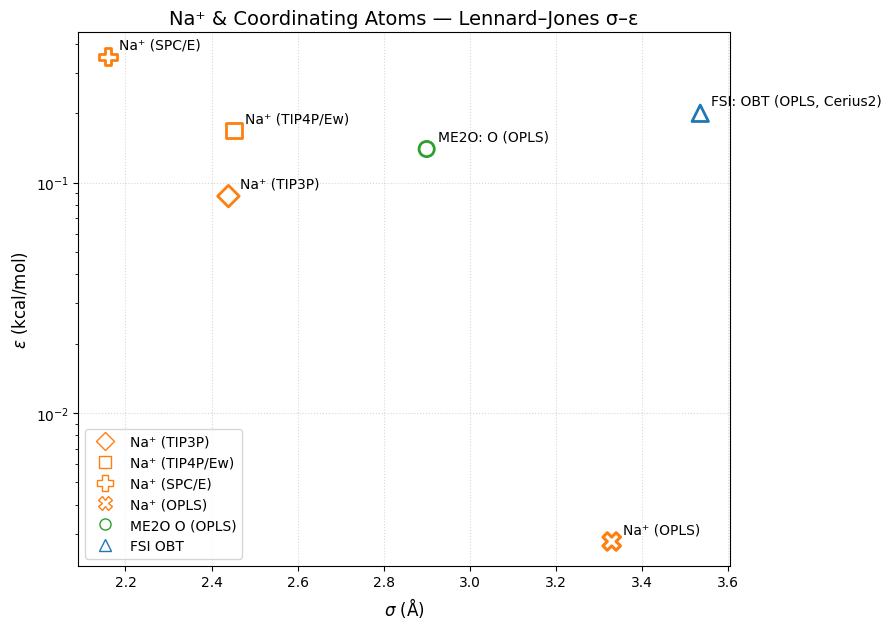

In [2]:
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# -------------------------------
# 상수 및 변환 함수
# -------------------------------
KJ_PER_MOL_TO_KCAL_PER_MOL = 0.239005736
TWO_POW_1_6 = 2.0 ** (1.0 / 6.0)

def rmin2_to_sigma(rmin_over_2: float) -> float:
    """JC 파라미터의 Rmin/2 값을 σ(Å)로 변환"""
    return (2.0 * rmin_over_2) / TWO_POW_1_6

def to_kcal(eps_value: float, unit: str) -> float:
    """에너지를 kcal/mol 단위로 변환"""
    unit = unit.lower()
    if unit in ["kcal", "kcal/mol", "kcal_per_mol"]:
        return eps_value
    elif unit in ["kj", "kj/mol", "kj_per_mol"]:
        return eps_value * KJ_PER_MOL_TO_KCAL_PER_MOL
    else:
        raise ValueError(f"Unknown epsilon unit: {unit}")

# -------------------------------
# 입력 데이터
# -------------------------------
# JC (Joung–Cheatham) — ε는 이미 kcal/mol
jc_entries = [
    ("Na⁺ (TIP3P)",    1.369, 0.0874393, "kcal"),
    ("Na⁺ (TIP4P/Ew)", 1.226, 0.1684375, "kcal"),  # ← 여기는 '형식상' 남겨두지만 아래에서 고정값으로 override
    ("Na⁺ (SPC/E)",    1.212, 0.3526418, "kcal"),
]

# OPLS/기타 — σ는 이미 Å, ε 단위만 맞추면 됨
opls_entries = [
    ("Na⁺ (OPLS)",      3.33,     0.01160,  "kJ"),
    ("ME2O: O (OPLS)",  2.90,     0.58576,  "kJ"),
    ("FSI: OBT (OPLS, Cerius2)", 3.53576, 0.200134, "kcal"),
]

# ▶▶ TIP4P/Ew Na+ 값을 변환 없이 '그대로' 쓰기 위한 고정값(override)
FIXED_SIGMA_EPS = {
    "Na⁺ (TIP4P/Ew)": (2.4520, 0.1684, "kcal"),  # σ[Å], ε[kcal/mol], 단위 표기
}

# -------------------------------
# 변환 및 데이터 정리
# -------------------------------
rows = []

# JC: 필요 시 override 적용
for label, rmin2, eps_val, eps_unit in jc_entries:
    if label in FIXED_SIGMA_EPS:
        sigma_fixed, eps_fixed, unit_fixed = FIXED_SIGMA_EPS[label]
        sigma = sigma_fixed
        eps_kcal = to_kcal(eps_fixed, unit_fixed)
    else:
        sigma = rmin2_to_sigma(rmin2)
        eps_kcal = to_kcal(eps_val, eps_unit)
    rows.append({"Model": label, "sigma_A": sigma, "epsilon_kcal_per_mol": eps_kcal})

# OPLS/기타
for label, sigma, eps_val, eps_unit in opls_entries:
    eps_kcal = to_kcal(eps_val, eps_unit)
    rows.append({"Model": label, "sigma_A": sigma, "epsilon_kcal_per_mol": eps_kcal})

# -------------------------------
# 플로팅
# -------------------------------
def style_for(model_label: str):
    """모델 라벨에 따른 마커 스타일"""
    if model_label == "Na⁺ (TIP3P)":
        return dict(marker="D", s=120, edgecolors="C1", facecolors="none", linewidths=2.0)
    if model_label == "Na⁺ (TIP4P/Ew)":
        return dict(marker="s", s=120, edgecolors="C1", facecolors="none", linewidths=2.0)
    if model_label == "Na⁺ (SPC/E)":
        return dict(marker="P", s=160, edgecolors="C1", facecolors="none", linewidths=2.0)
    if "Na⁺ (OPLS)" in model_label:
        return dict(marker="X", s=160, edgecolors="C1", facecolors="none", linewidths=2.2)
    if "ME2O" in model_label:
        return dict(marker="o", s=120, edgecolors="C2", facecolors="none", linewidths=2.0)
    if "FSI" in model_label:
        return dict(marker="^", s=140, edgecolors="C0", facecolors="none", linewidths=2.0)
    return dict(marker="o", s=110, edgecolors="k", facecolors="none", linewidths=1.5)

fig, ax = plt.subplots(figsize=(9.0, 6.4))

for r in rows:
    x = r["sigma_A"]
    y = r["epsilon_kcal_per_mol"]
    st = style_for(r["Model"])
    ax.scatter([x], [y], **st)
    ax.annotate(r["Model"], (x, y), xytext=(8, 6), textcoords="offset points", fontsize=10)

ax.set_xlabel(r"$\sigma$ (Å)", fontsize=12)
ax.set_ylabel(r"$\varepsilon$ (kcal/mol)", fontsize=12)
ax.set_yscale("log")
ax.grid(True, ls=":", alpha=0.5)
ax.set_title("Na⁺ & Coordinating Atoms — Lennard–Jones σ–ε", fontsize=14)
plt.tight_layout()

legend_handles = [
    Line2D([], [], marker='D', markersize=9, linestyle='None', markerfacecolor='none', markeredgecolor='C1', label='Na⁺ (TIP3P)'),
    Line2D([], [], marker='s', markersize=9, linestyle='None', markerfacecolor='none', markeredgecolor='C1', label='Na⁺ (TIP4P/Ew)'),
    Line2D([], [], marker='P', markersize=11, linestyle='None', markerfacecolor='none', markeredgecolor='C1', label='Na⁺ (SPC/E)'),
    Line2D([], [], marker='X', markersize=10, linestyle='None', markerfacecolor='none', markeredgecolor='C1', label='Na⁺ (OPLS)'),
    Line2D([], [], marker='o', markersize=8, linestyle='None', markerfacecolor='none', markeredgecolor='C2', label='ME2O O (OPLS)'),
    Line2D([], [], marker='^', markersize=9, linestyle='None', markerfacecolor='none', markeredgecolor='C0', label='FSI OBT'),
]
ax.legend(handles=legend_handles, loc='best', frameon=True)

out_png_new = Path("sigma_epsilon_compiled_renamed.png")
plt.savefig(out_png_new, dpi=220)
plt.show()